# Clustering India's Urban Cities - Report

This report supports the Applied Data Science Capstone project. It lays out the problem being solved, the dataset used, the model and algorithm adopted and the results.

1. [Introduction](#introduction)  
    1.1. [Context](#1.1)  
    1.2. [Problem Statement](#1.2)  
    1.3. [Audience](#1.3)  
2. [Data](#2)  
    2.1. [Data Sources](#2.1)  
    2.2. [Data Cleansing](#2.2)  
3. [Exploratory Data Analyses](#3)  
    3.1. [Common and High-frequency Venue categories](#3.1)  
    3.2. [Venue Categories Per City](#3.2)  
    3.3. [Cities Visualization](#3.3)  
    3.4. [Feature Selection](#3.4)  
4. [Methodology](#4)  
    4.1. [K-Means Clustering](#4.1)  
    4.2. [Choosing K](#4.2)  
5. [Results](#5)  
    5.1. [Clusters](#5.1)  
    5.2. [Map Visualization](#5.2)  
6. [Discussion](#6)  
    6.1. [Clusters](#6.1)  
    6.2. [Limitations and Future Recommendations](#6.2)  
7. [Conclusion](#7)  

In [13]:
# Downloading images from the Project Cloud for the Report

FileList = {'Elbow.png',
            'PostClusterMap.JPG',
            'PreClusterMap.JPG',
            'Silhouette.png',
            'VenueCategories.png'}


from ibm_botocore.client import Config
import ibm_boto3

def download_file_cos(credentials, local_file_name, key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'], Key=key, Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print("Dowloaded:", key, 'from IBM COS to local:', local_file_name)

for local_file_name in FileList:
    download_file_cos(credentials_1, local_file_name, local_file_name)


Dowloaded: Elbow.png from IBM COS to local: Elbow.png
Dowloaded: VenueCategories.png from IBM COS to local: VenueCategories.png
Dowloaded: PreClusterMap.JPG from IBM COS to local: PreClusterMap.JPG
Dowloaded: Silhouette.png from IBM COS to local: Silhouette.png
Dowloaded: PostClusterMap.JPG from IBM COS to local: PostClusterMap.JPG


## 1. Introduction
<a id='introduction'></a>

### 1.1 Context
<a id='1.1'></a>

The Ministry for Urban Development in India recently launched a Smart City Mission as an initiative to develop cities across the country. The objectives are to make cities more urban, citizen-friendly and sustainable. The country views this as the best route in embracing the opportunity of an increasing urban population.

Around 100 cities across India were chosen in 2015 to partake in this mission. This initial selection was based on a 'City Challenge' where contending cities were evaluated against parameters like economic status, livability and adoption of information/communication technology among others.

### 1.2 Problem Statement
<a id='1.2'></a>

In keeping with the ultimate objective of the Smart City Mission, it is important to identify other cities in the country that can benefit from urban development and retrofitting. While several parameters will likely determine their eligibility, cities' urban activity can be used to understand their character and likeness to participating cities.

This project aims to explore, segment and cluster India's urban cities into groups based on similarities or differences in urban activity reported. 

### 1.3 Audience
<a id='1.3'></a>

The intended audience for this project is the Ministry for Urban Development in India. The outcome should enable them to 
1) identify other cities not currently participating that may benefit from the Smart City Mission, and
2) the nature of urban development that they may require, and specific projects to implement based on other cities in the group

## 2. Data
<a id='2'></a>

### 2.1 Data Sources
<a id='2.1'></a>

This project uses two data sources.

1. The World Cities Database provided by simplemaps. This is a CSV file containing a list of prominent cities and towns from every country in the world.

2. The Foursquare API to get the most common venue categories visitied in each city.

#### 2.1.1 World Cities Database

The World Cities Database (https://simplemaps.com/data/world-cities) has a list of prominent cities from all countries in the world, along with their geo coordinates. A sample from the World Cities Database CSV file is shown below. 

| city | city_ascii | lat | lng | country | iso2 | iso3 | admin_name | capital | population | id |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Kabul | Kabul | 34.5167 | 69.1833 | Afghanistan | AF | AFG | Kābul | primary | 3277000 | 1004993580 |
| Sharan | Sharan | 33.1757 | 68.7304 | Afghanistan | AF | AFG | Paktīkā | admin | --- | 1004273142 |

The fields of interest for this study are listed below along with an explanation. The initial data exploration phase will filter for cities in India (country = 'India')

| Field | Description |
| --- | --- |
| city | The name of the city/town as a Unicode string |
| lat | The latitude of the city/town |
| lng | The longitude of the city/town |
| country | The name of the city/town's country |
| capital | Blank string if not a capital, otherwise: <br> primary - country's capital (e.g. Washington D.C.) <br> admin - first-level admin capital (e.g. Little Rock, AR) <br> minor - lower-level admin capital (e.g. Fayetteville, AR)



#### 2.1.2 Foursquare API

Foursquare is a social networking mobile app that enables users to 'check-in' and share their location when they visit venues. While users of the app can obtain local recommendations and tips, Foursquare's wealth of location data is available to developers and businesses via an API. For a given geolocation, the API can return venues in the area and details for each venue like their popularity, hours of operation, ratings and type of business. 

This project will use the 'Search for Venues' and 'Get Details of Venue' features of the Foursquare API to find out the nature of locations being visited in each city. The most popular venue types will then be used as the bases to determine similar cities.

### 2.2 Data Cleansing
<a id='2.2'></a>

The following steps were taken to structure the data to be relevent to this project.

**1. Extract only Indian cities**  
Since the extract from the World Cities Database contains cities from all countries, a new dataframe is created with only cities in India. This is done by filtering for the value of 'country' being India

> 212 Indian cities were extracted

**2. Remove redundant columns**  
The 'iso2' and 'iso3' columns are alternate representations for country. They are dropped from further analyses as only one country is in consideration and they add no value in that regard. The 'admin_name' which denotes the state a city belongs to is dropped as this is not expected to be a feature during analysis. The 'id' for the city is also dropped as the city name will serve as index.

> 212 cities remained

**3. Remove cities with Zero venues (no Foursquare checkins) or too few venues**  
Some cities had no Foursquare checkins, and therefore no venue data to use for analysis. Such cities were eliminated from subsequent analysis and modelling as this would unnecessarily skew the results. Cities with only 5 checkins were also removed, as it was deemed this data would not be representative of the population. A minimum of 5 venues was arrived at based on the feature set of 5 venue categories arrived at eventually. 

> 210 cities remained

**4. Consolidate highly common and frequent venue categories**  
The next section (3.1) explains tha analysis carried out on venue data from Foursquare. A number of venue categories were deemed similar for the purpose of this project. When consolidated they would be less useful as they were widely prevelant (present in over 70% of the cities), and less likely to distinguish between cities. Such categories were removed from the dataset.

> 210 cities remained

Since the modelling algorithm uses the top 10 venue categories to perform clustering, any cities with fewer than 10 unique venues were also eliminated. These cities were initially included in the process, but from the results they appeared to be in irrelevant clusters presumably due to fewer 'features' available for them.



## 3. Exploratory Data Analysis
<a id='3'></a>

### 3.1 Common and High-frequency Venue Categories
<a id='3.1'></a>

Out of the 268 unique venue categories obtained from Foursquare, a frequency of their occurance across cities was determined. The distribution indicated the following were the top 5 most common venue categories and the number of cities they were present in (over 50% of the cities).

**Top 5 most common venue categories across all cities**

       Venue Category	No. of cities
    ------------------|---------------
    Indian Restaurant	154
                Hotel	136
                 Café	135
        Train Station	114
          Pizza Place	109
    ------------------|---------------
    
A quick visual check showed that the top categories above were also the most frequent occuring within most cities. Due to the fact that a venue category existing within a majority of the cities in high numbers would likely overshadow other venues that may be characteristic of the cities, the top 3 categories were removed from the Foursquare dataset. This was limited to the 3 categories that were present in over 70% of the cities, and hence deemed highly prevelant.

### 3.2 Venue categories per city
<a id='3.2'></a>

A final summary of unique venue categories per city is shown below. With a median of 10 unique categories, 50% of the cities have 10 or lower unique venue categories. 70% of cities have at least 5 unique venue categories.

Avg number of unique venues per city:  14.5
Max number of unique venues in a city:  47
Min number of unique venues in a city:  1
Number of unique venues at median:  10
Number of unique venues at 30% point:  5.0

![VenueCategories.png](attachment:VenueCategories.png)

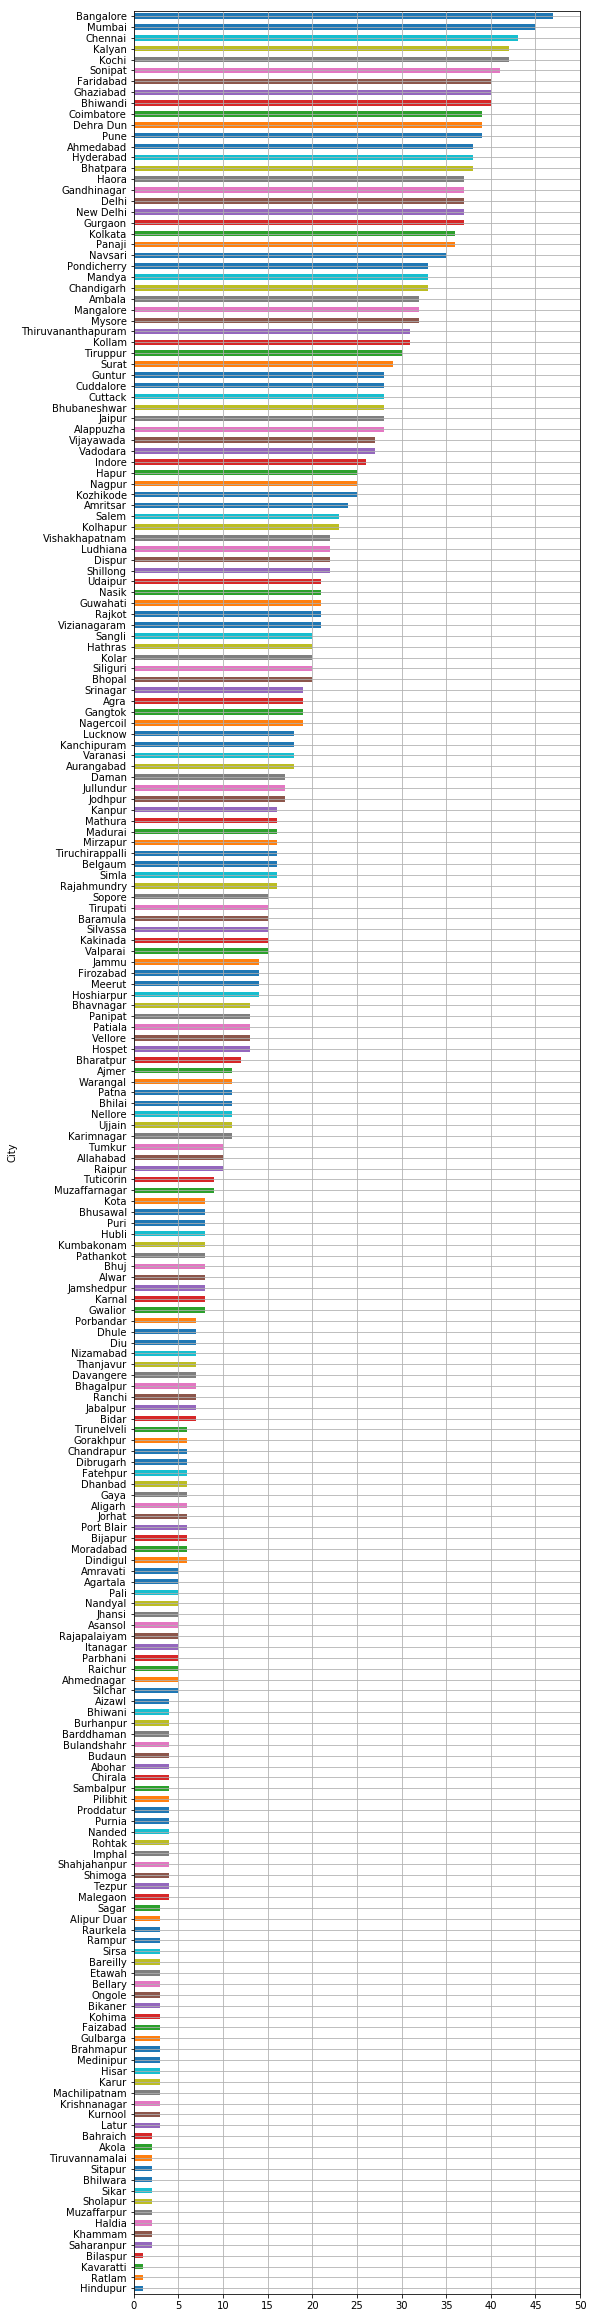

In [14]:
from IPython.display import Image
Image(filename="VenueCategories.png")

### 3.3 Cities Visualization
<a id='3.3'></a>

Following is a map of India with the 184 cities plotted.

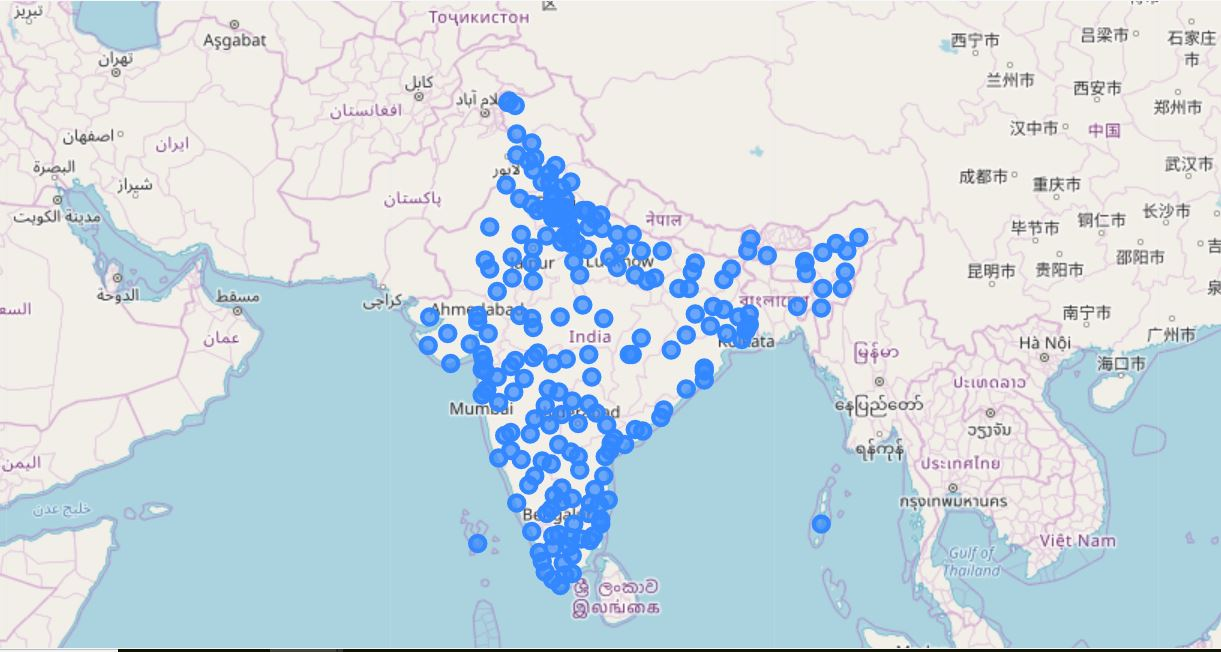

In [16]:
from IPython.display import Image
Image(filename="PreClusterMap.JPG")

### 3.4 Feature Selection
<a id='3.4'></a>

After data cleansing, there were 210 cities and 268 unique venue categories. There were an average of 14.5 unique categories per city, 47 in the city with the most categories and 1 in the least. 30% of cities had 5 or lower unique venue categories. 

- **Venue categories**: It was decided that the top 5 venue categories (based on number of checkins) will be used as the feature set to compare cities. This number was chosen as it was high enough to have meaningful features, and low enough to have at least 70% of cities with all 5 features populated. The remaining cities with fewer venue categories would have a blank in the other features.
- **Population**: An attempt was made to include population as a feature, as this would also determine the facilities a city needed. However, the resulting cluster allocations were influenced by Population to a much larger extent than the Foursquare data. For this reason, population was NOT included in the feature set.

## 4. Methodology
<a id='4'></a>

### 4.1 K-means Clustering
<a id='4.1'></a>

A clustering approach is adopted for this problem as the objective is to find groups of cities that have similarities. Rather than defining groups before looking at the data, clustering allows  to find and analyze the groups that have formed organically. 

K-means clustering is a type of unsupervised learning that iteratively tries to partition the dataset into 'K' pre-defined distinct non-overlapping subgroups (clusters). The results of the K-means clustering algorithm are:

1. The centroids of the K clusters. Each centroid of a cluster is a collection of feature values which define the resulting groups.
2. Labels for the data. Each data point is assigned to only one cluster.

### 4.2 Choosing K - Optimal number of clusters
<a id='4.2'></a>

An cluster count of 8 was arrived at based on the two methods described below.

#### 4.2.1 Elbow method

To find the optimal number of clusters in the data, the K-means clustering algorithm is executed for a range of K values. The Average within-cluster distance to centroid (sum of squared error SSE) is then calculated. The distribution of this value with respect to the K value is plotted on a line graph. We pick k at the spot where SSE starts to flatten out and forming an elbow. Elbow method provides an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. 

The idea is that the SSE should be small, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). The goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

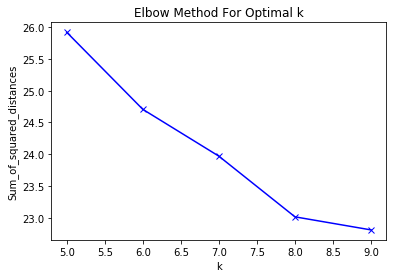

In [17]:
from IPython.display import Image
Image(filename="Elbow.png")

#### 4.2.2 Average Silhouette method

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

The Silhouette coefficients are calculated for a range of cluster values. Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.


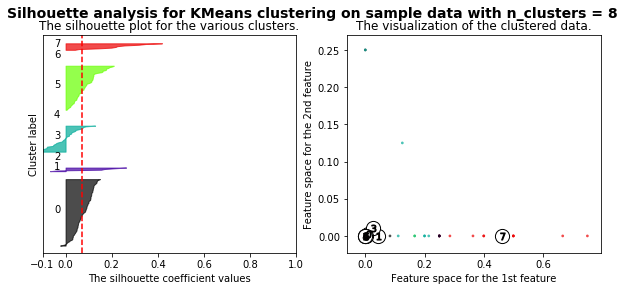

In [18]:
from IPython.display import Image
Image(filename="Silhouette.png")

## 5. Results
<a id='5'></a>

### 5.1 Clusters
<a id='5.1'></a>

Eight clusters were formed, each with different sizes. The cities have been plotted on the map with colors corresponding to their clusters.

Cluster 1 - 10 cities  
Cluster 2 - 77 cities  
Cluster 3 - 11 cities  
Cluster 4 - 62 cities  
Cluster 5 - 4 cities  
Cluster 6 - 1 city  
Cluster 7 - 9 cities  
Cluster 8 - 37 cities  

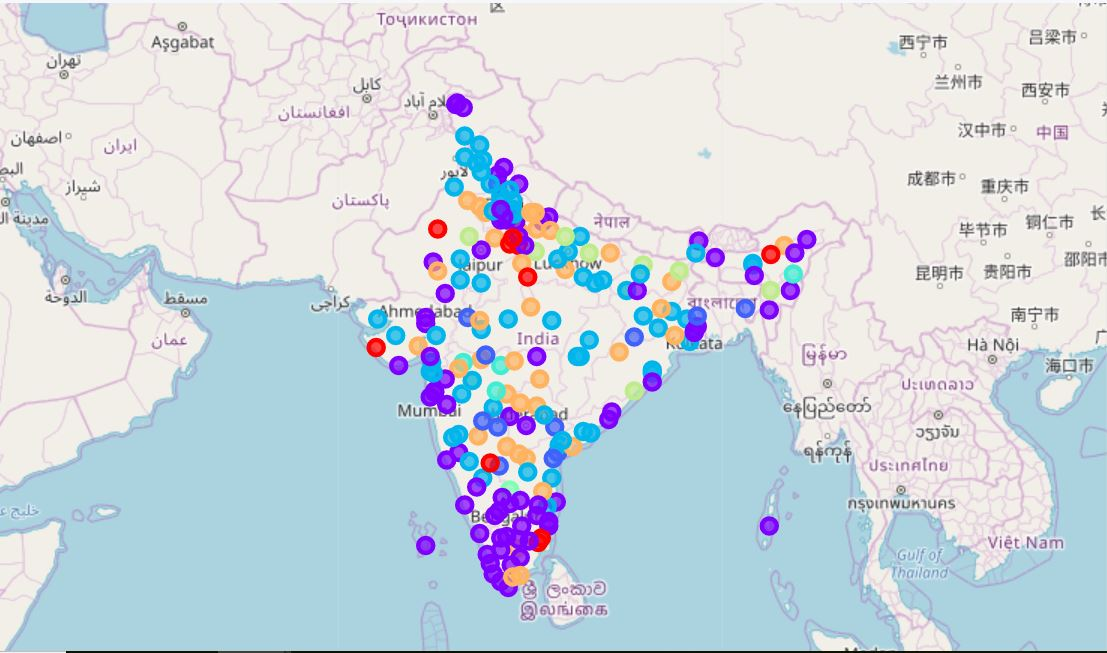

In [19]:
from IPython.display import Image
Image(filename="PostClusterMap.JPG")

## 6. Discussion
<a id='6'></a>

### 6.1 Clusters
<a id='6.1'></a>

From examining the cities in each cluster and their most common venues, the following themes were identified for each cluster:

#### **Cluster #1 - Historic sites**   
Cities in this cluster were touristic places, specifically known for historic sites. **Agra** is a current Smart City that can serve as a model. 

#### **Cluster #2 - Urban I**  
This cluster was the largest in size and appeared to have most metropolitan cities in the country. **Ahmedabad** is one of the current Smart Cities among others in this group.

#### **Cluster #3 - Railway junctions**   
The most visited venue is these cities were train stations. While most cities in India have train stations and railway connection, some smaller towns serve as key junctions for main routes. **Sholapur** in this cluster is a current Smart City to model on.

#### **Cluster #4 - Mid-size towns I**   
The second largest cluster, there was no distinguishing feature visible in this group except the cities appeared to be the smaller towns in the country. **Lucknow** is a current Smart City in this group.

#### **Cluster #5 - Outliers I**   
One of the four smaller groups, the venue categories did not convey much about the cluster. **Kohima** is a current Smart City in this cluster.

#### **Cluster #6 - Outlier II**   
This cluster contained one city with one venue category. The venue was 'temple' which is a largely prevelent category in the country. For this reason, this city requires other data and features for better classification.

#### **Cluster #7 - Mid-size towns II**   
One of the smaller clusters, this appeared to be another group of smaller towns. However, like Cluster 6, further data is needed for accurate classification. **Muzaffarpur** is a current Smart City.

#### **Cluster #8 - Mid-size towns III**   
This cluster had a slighlty longer list of smaller towns, but no distinguishing feature was visible. **Gwalior** a current Smart City could serve as model for the others.

  

### 6.2 Limitations and Future Recommendations
<a id='6.2'></a>

The following limitations have been identified from the results:

1. **Data - Reliance on Foursquare checkins:** Foursquare checkins were essentialy the only source of information in this project. The volume of Foursquare data available varied widely across cities. In reality, this data may not be representative of true characteristics of a city. While the clustering was probably reasonable based on the data available, the cities within a cluster may require different treatments with respect to the problem in question. *Additional feature data relating to infrastructure, employment, population, income, industries etc. need to be considered*
2. **Lack of Feature Scaling:** The output of the Silhouette method showed that an even-width distribution of clusters was not obtained for any number of clusters. This may be due to one of the features dominating the clusters. *Feature scaling should be explored to mitigate this, but was not done due to time constraints.*
2. **Choice of Algorithm:** Overall, it appeared that K-Means may not have been the best suited algorithm for this dataset, as a definitive elbow not achieved in the squared error analysis. Also, some clusters were much larger than others because K-Means may have been very sensitive to some of the data. *A more robust implementation of DBSCAN or other such algorithms could be explored.*

## 7. Conclusion
<a id='7'></a>

This project produced a clustering of Indian cities to aid the smart cities initiative in the country. However, there are limitations that need to be addressed to produce more accurate results, and these have been documented